# Install all the dependencies

In [ ]:
%pip install --upgrade deepforest albumentations certifi PyYAML scikit-image

# Import all the necessary libraries

In [239]:
from PIL import Image
import math
from rasterio import windows
import rasterio

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import torch
import os
import certifi

import imageio
from skimage import exposure

from deepforest import main
from deepforest import get_data
from deepforest import utilities
from deepforest import preprocess

import geopandas as gpd
import pandas as pd
from shapely.geometry import box

os.environ['SSL_CERT_FILE'] = certifi.where()

# Increase the maximum number of pixels PIL can handle
# We need to do this because some of the High-Res tif files are too big
Image.MAX_IMAGE_PIXELS = None

# Load the default DeepForest Pre-trained Model 

In [256]:
m = main.deepforest()
# m.use_release()
m = main.deepforest.load_from_checkpoint('SkogAppModel')


Reading config file: /Users/hesam.ossanloo/Projects/Startup/SkogApp/DeepForest/.venv/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


No validation file provided. Turning off validation loop
Reading config file: /Users/hesam.ossanloo/Projects/Startup/SkogApp/DeepForest/.venv/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


/Users/hesam.ossanloo/Projects/Startup/SkogApp/DeepForest/.venv/lib/python3.11/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.2.1, which is newer than your current Lightning version: v2.2.0.post0
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


No validation file provided. Turning off validation loop


# Check if the current hardware has GPU

### Check if PyTorch recognizes the GPU on Apple M chips

In [5]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print("Current device has MPS a.k.a GPU")
    print(x)
else:
    print("Current device does not have MPS")

Current device has MPS a.k.a GPU
tensor([1.], device='mps:0')


In [218]:
# Check if CUDA is available
if torch.cuda.is_available() and torch.cuda.get_device_name(0) != "Apple M1":
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Current device is {}".format(device))

Current device is cpu


# Assign the current model to the available device

In [257]:
# m.to(device)
m.to(mps_device)

deepforest(
  (model): RetinaNet(
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d(64, eps=0.0)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d(64, eps=0.0)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): FrozenBatchNorm2d(256, eps=0.0)
            (relu): ReLU(inplace=True)
            (downsample): Sequential(
              (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias

# Define al lthe path variables

In [261]:
# Define all global variables, to be used across Notebook cell
raster_dir_path = "./"
raster_name = "0_1"
raster_name_enhanced = raster_name+"_enhanced_MinMax"
raster_format = ".tif"
raster_path_default = raster_dir_path+raster_name+raster_format
raster_path_enhanced = raster_dir_path + raster_name_enhanced + raster_format
shapefile_name = raster_name + "_bounds.shp"
shapefile_path = raster_name + "_bounds.shp"
v2_csv_name = "v2_" + raster_name + "_bounds.csv"
v1_csv_name = "v1_" + raster_name + "_bounds.csv"
merge_two_csv_name = "merged_bounds.csv"
raster_path = raster_path_default

# Read and Show the raster image
Please download the Raster data (i.r. TIF/TIFF images under the "./data/images/Kartverket/" folder structure)

For SkogApp employee:
- The raster files you see in this notbook can be found on the SkogApp Google Drive, in this path:
`SkogApp > Technical > Raster-Vector-Data >`

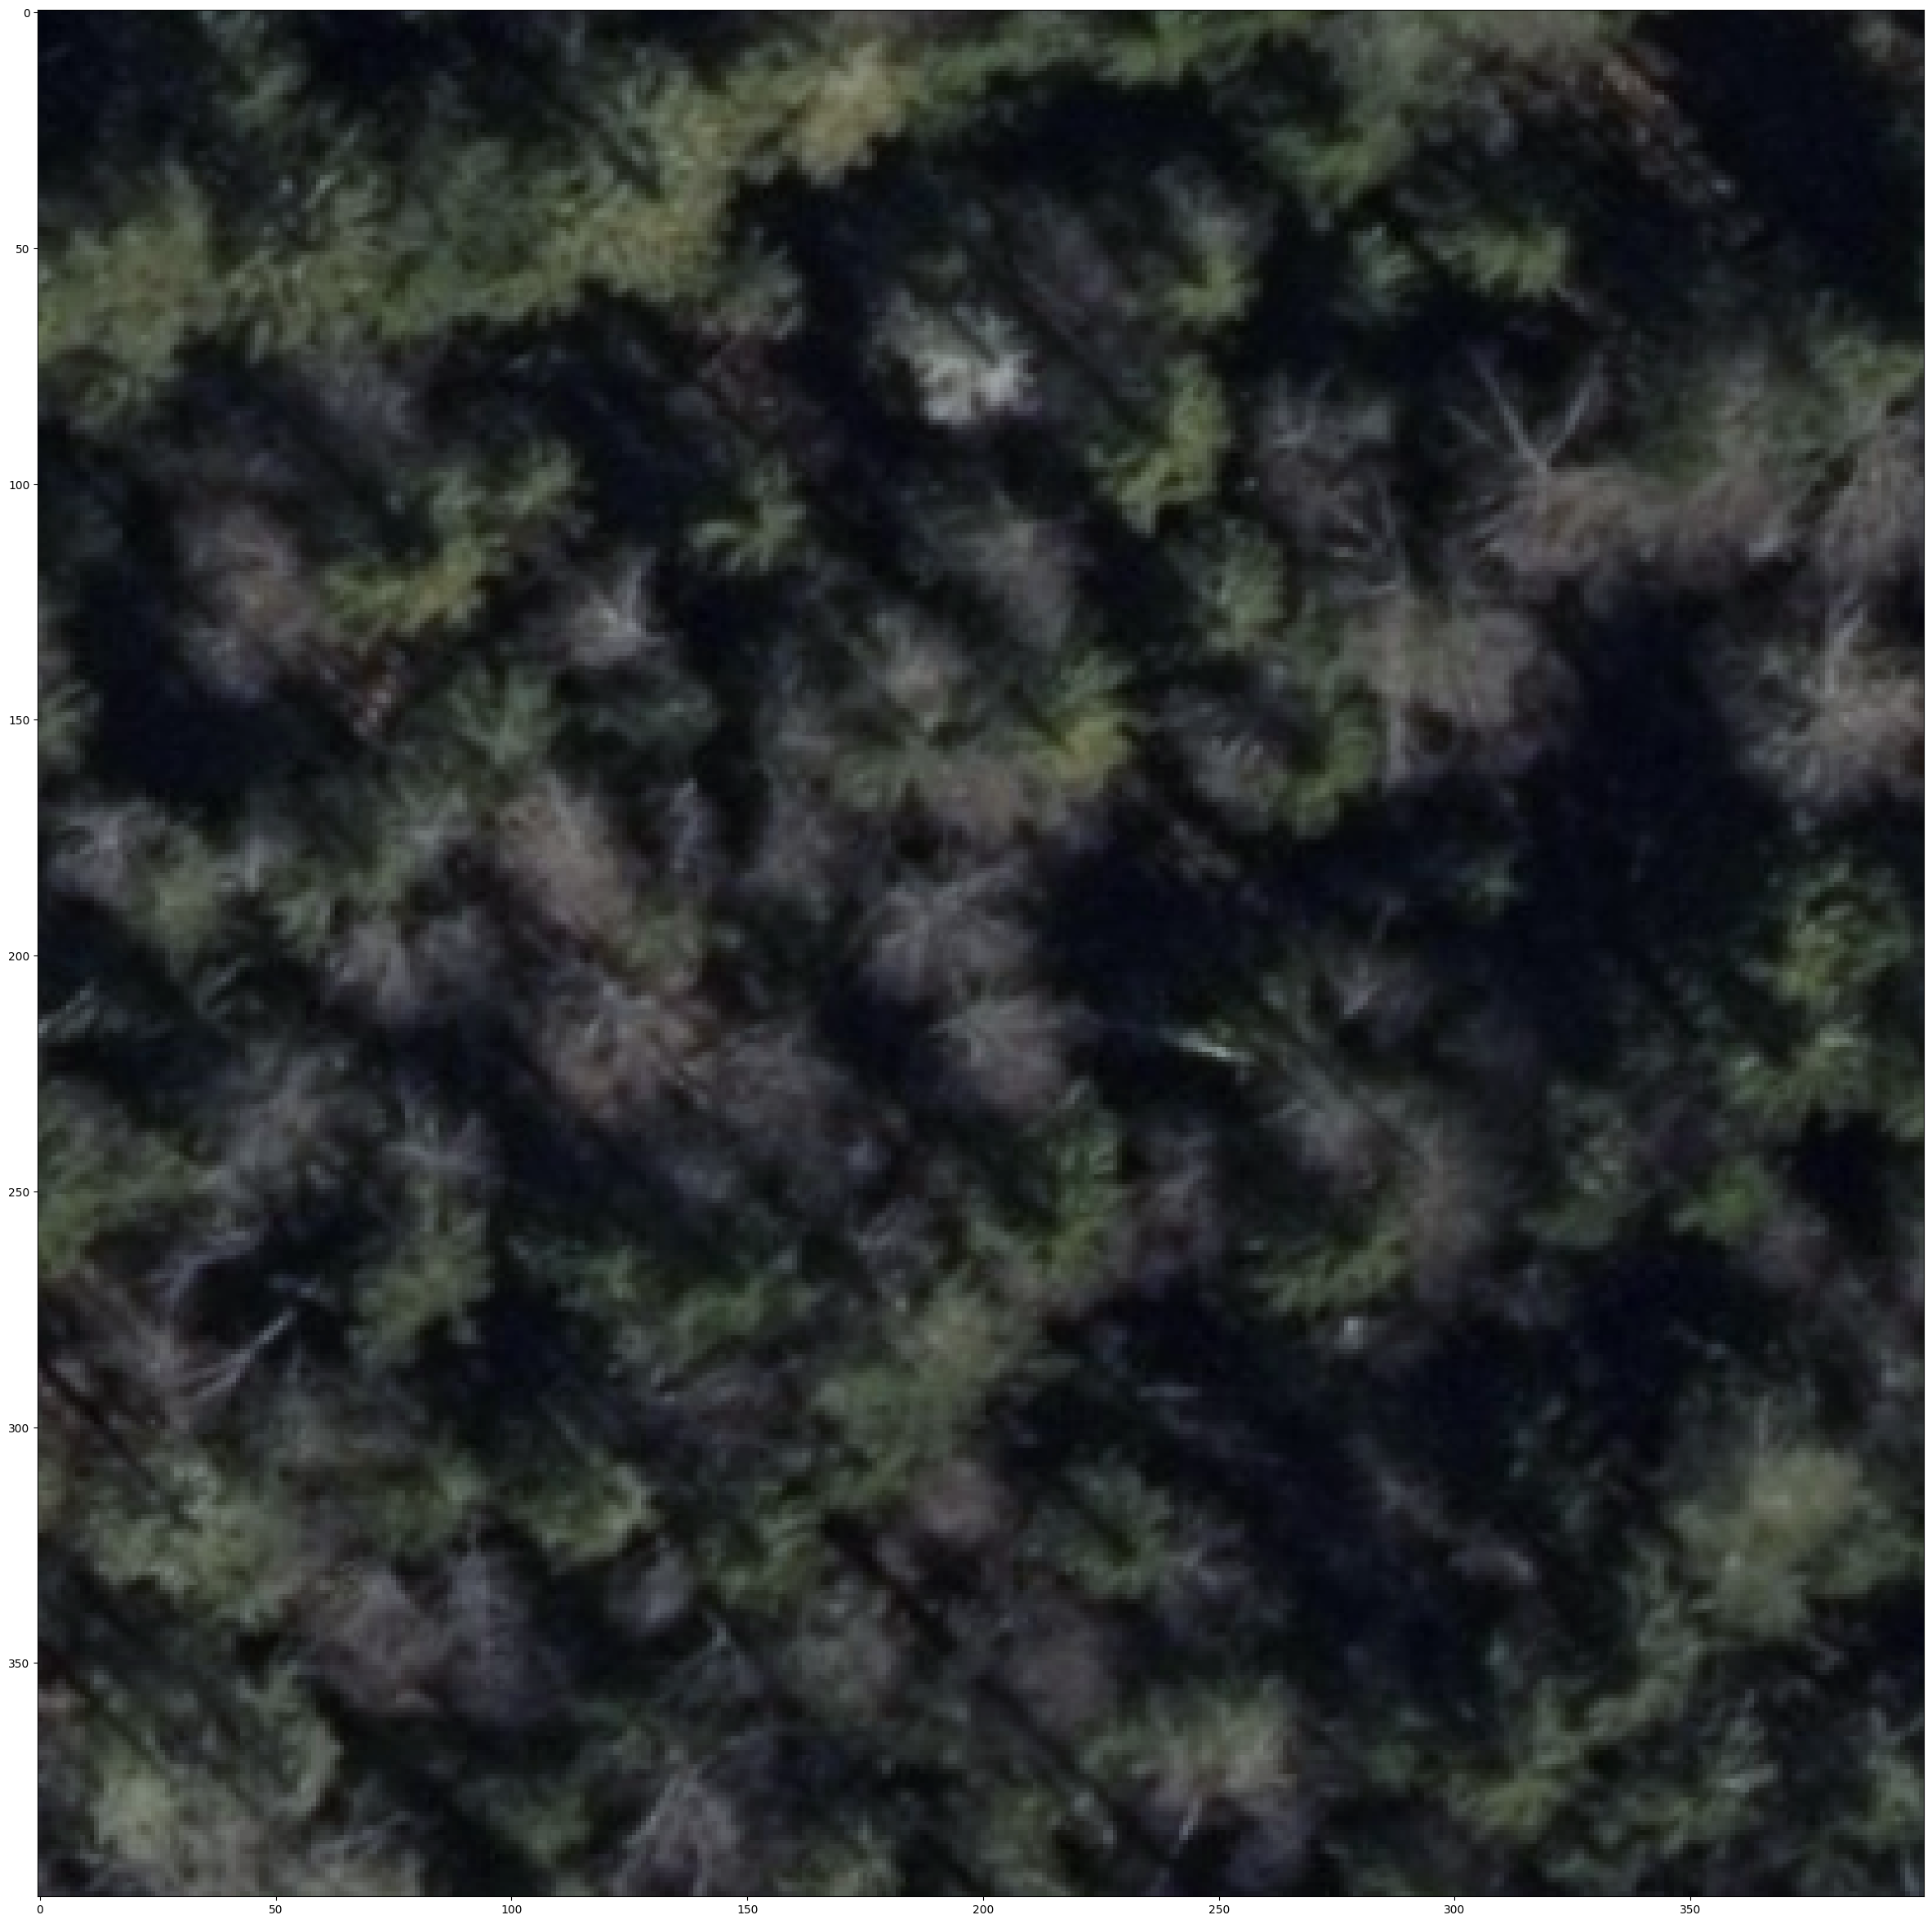

In [262]:

raster = rasterio.open(raster_path).read()

# change from channels first (C, H, W) to channels last (H, W, C) for plotting
raster = np.rollaxis(raster, 0, 3)

plt.figure(figsize=(30, 30))
plt.imshow(raster)

# Exlude the Alpha Channel and save the new image

In [265]:
# Open the image
with rasterio.open(raster_path) as src:
    # Read the Geo data
    transform = src.transform
    crs = src.crs

    # Read the image data and exclude the alpha channel
    rgb_image = src.read([1, 2, 3])

no_alpha_raster_path = raster_dir_path + raster_name+'_RGB'+raster_format
print(no_alpha_raster_path)

# Write the new image to a new file
with rasterio.open(no_alpha_raster_path, 'w', driver='GTiff', height=rgb_image.shape[1], width=rgb_image.shape[2], count=3, dtype=rgb_image.dtype, crs=crs, transform=transform) as dst:
    dst.write(rgb_image)

./0_1_RGB.tif


# Cutting larger images into smaller pieces (PNG, no geo locations)

In [127]:
def split_image_to_PNG(image_path, dest_folder, tile_size):
    image = Image.open(image_path)
    # image_name = os.path.splitext(os.path.basename(image_path))[0]

    os.makedirs(dest_folder, exist_ok=True)

    width, height = image.size
    h_tiles = math.ceil(width / tile_size)
    v_tiles = math.ceil(height / tile_size)

    for i in range(h_tiles):
        for j in range(v_tiles):
            left = i * tile_size
            upper = j * tile_size
            right = min(left + tile_size, width)
            lower = min(upper + tile_size, height)

            tile = image.crop((left, upper, right, lower))
            tile.save(os.path.join(dest_folder, f"{i}_{j}.png"))
            # tile.save(os.path.join(dest_folder, f"{image_name}_{i}_{j}.png"))


# Example usage:
tile_size = 400
print(no_alpha_raster_path, raster_dir_path, tile_size)
split_image_to_PNG(no_alpha_raster_path, raster_dir_path, tile_size)

./0_0_RGB.tif ./ 400


# Cutting larger images into smaller pieces (TIF, with geo locations)

In [128]:
def split_geotiff_w_geo_loc(image_path, dest_folder, tile_size):
    with rasterio.open(image_path) as src:
        out_meta = src.meta.copy()

        # Calculate the number of tiles in each dimension
        width_tiles = math.ceil(src.width / tile_size)
        height_tiles = math.ceil(src.height / tile_size)

        for i in range(width_tiles):
            for j in range(height_tiles):
                # Calculate window position
                x = i * tile_size
                y = j * tile_size
                w = min(tile_size, src.width - x)
                h = min(tile_size, src.height - y)

                # Define the window
                window = windows.Window(x, y, w, h)
                out_meta['transform'] = rasterio.windows.transform(
                    window, src.transform)

                # Update the metadata for the tile
                out_meta['width'], out_meta['height'] = w, h

                # Set output path for the tile
                out_path = os.path.join(dest_folder, f"{i}_{j}.tif")

                # Ensure the destination folder exists
                os.makedirs(dest_folder, exist_ok=True)

                # Read and save the tile with updated metadata
                with rasterio.open(out_path, 'w', **out_meta) as dest:
                    dest.write(src.read(window=window))


tile_size = 400

split_geotiff_w_geo_loc(no_alpha_raster_path, raster_dir_path, tile_size)

# Predict Objects

### Predict trees in the forest and show the scores and coordination of the predicted boxes

In [266]:
predicted_image = m.predict_tile(
    raster_path=no_alpha_raster_path, return_plot=False, color=(
        0, 165, 255), patch_size=400)
# raster_path=new_file_path_RGB, return_plot=False, color=(
#     0, 165, 255), patch_overlap=0.25, iou_threshold=0.05, patch_size=400)
predicted_image.head()

/Users/hesam.ossanloo/Projects/Startup/SkogApp/DeepForest/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  0.90it/s]
67 predictions in overlapping windows, applying non-max supression
67 predictions kept after non-max suppression


,xmin,ymin,xmax,ymax,label,score,image_path
0,354.0,122.0,400.0,169.0,Tree,0.788692,0_1_RGB.tif
1,340.0,285.0,398.0,341.0,Tree,0.770979,0_1_RGB.tif
2,0.0,26.0,44.0,86.0,Tree,0.733145,0_1_RGB.tif
3,28.0,211.0,72.0,255.0,Tree,0.722389,0_1_RGB.tif
4,222.0,70.0,261.0,108.0,Tree,0.716251,0_1_RGB.tif


### Show the predicted boxes on top of the original image

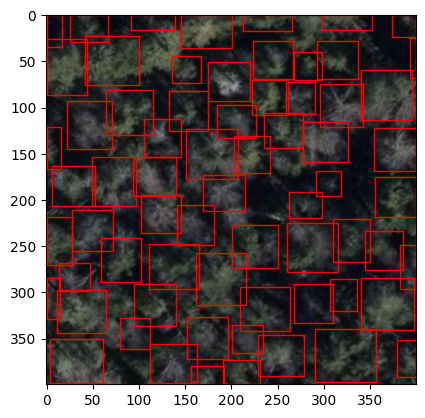

In [267]:
# Load the original image
with rasterio.open(no_alpha_raster_path) as src:
    img = src.read()
    img = np.rollaxis(img, 0, 3)  # Change from (C, H, W) to (H, W, C)

# Create a new plot
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(img)

# Draw each box
for _, row in predicted_image.iterrows():
    xmin = row['xmin']
    ymin = row['ymin']
    width = row['xmax'] - xmin
    height = row['ymax'] - ymin

    rect = patches.Rectangle((xmin, ymin), width, height,
                             linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

# Show the plot
plt.show()

# Fintune the model

### STEP1 (Self implemented logic with CRS)
Create the CSV file in the format that DeepForest expects
image_path, xmin, ymin, xmax, ymax, label

In [200]:
# I have a shapefile with bounding boxes. I want to convert them into a csv file in the following format:
# image_path, xmin, ymin, xmax, ymax, label

# Load the shapefile
gdf = gpd.read_file(shapefile_path)

# Display the first few rows of the GeoDataFrame
gdf.head()

# Create a DataFrame with the required columns
v1_df_csv = pd.DataFrame(columns=['image_path', 'xmin',
                                  'ymin', 'xmax', 'ymax', 'label'])

# Iterate over each row in the GeoDataFrame
for index, row in gdf.iterrows():
    # Extract the bounding box coordinates
    xmin, ymin, xmax, ymax = row['geometry'].bounds

    # Extract the label
    label = 'Tree'

    # Append the data to the DataFrame
    v1_df_csv = pd.concat([v1_df_csv, pd.DataFrame(
        [{'image_path': raster_name+raster_format, 'xmin': xmin, 'ymin': ymin, 'xmax': xmax, 'ymax': ymax, 'label': label}])], ignore_index=True)


# Save the DataFrame to a CSV file
v1_csv_file_path = raster_dir_path + v1_csv_name
v1_df_csv.to_csv(v1_csv_file_path, index=False)

# Load the CSV file
v1_df_csv = pd.read_csv(v1_csv_file_path)

# Display the first few rows of the DataFrame
v1_df_csv.head()

/var/folders/wq/rtjbr_1d49jddhxkh6hfjrlc0000gp/T/ipykernel_7975/693017262.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  v1_df_csv = pd.concat([v1_df_csv, pd.DataFrame(


,image_path,xmin,ymin,xmax,ymax,label
0,0_0.tif,315600.017215,6.648298e+06,315601.806271,6.648300e+06,Tree
1,0_0.tif,315606.609220,6.648297e+06,315613.369878,6.648300e+06,Tree
2,0_0.tif,315600.031283,6.648289e+06,315604.782015,6.648294e+06,Tree
3,0_0.tif,315615.920205,6.648298e+06,315622.845366,6.648300e+06,Tree
4,0_0.tif,315626.721714,6.648298e+06,315632.514459,6.648300e+06,Tree


### Get annotation file ready

In [245]:
# convert hand annotations from shapefile into retinanet format
# The get_data function is only needed when fetching sample package data

shapefile = get_data(shapefile_path)
annotation = utilities.shapefile_to_annotations(shapefile=shapefile_path, rgb=raster_path, buffer_size=0.5,
                                                geometry_type='bbox', savedir='.')
annotation.head()

,image_path,xmin,ymin,xmax,ymax,label
0,0_0.tif,0,0,18,19,Tree
1,0_0.tif,66,1,133,33,Tree
2,0_0.tif,0,61,47,111,Tree
3,0_0.tif,159,0,228,22,Tree
4,0_0.tif,267,1,325,22,Tree


### Save as CSV (No CRS)

In [246]:
import os
# load the image file corresponding to the annotaion file
print('Relative path:', raster_path)
print('Directory path:', raster_dir_path)

# Write converted dataframe to file. Saved alongside the images
annotation.to_csv(os.path.join(
    raster_dir_path, v2_csv_name), index=False)

Relative path: ./0_0.tif
Directory path: ./


### Split Train and Test dataset

### Merge two CSVs

In [247]:
# Merge two V2 csvs together and call it with the value of the merge_two_csv_name
img_0_0_annotations = pd.read_csv(os.path.join(raster_dir_path, "v2_0_0_bounds.csv"))
img_0_1_annotations = pd.read_csv(os.path.join(raster_dir_path, "v2_0_1_bounds.csv"))
merged_annotations = pd.concat([img_0_0_annotations, img_0_1_annotations], ignore_index=True)

# Now save it next to the others
merged_annotations.to_csv(os.path.join(raster_dir_path, merge_two_csv_name), index=False)

### Split 25%

In [248]:
number_of_image_paths = merged_annotations.image_path.unique()
print(number_of_image_paths)
print(len(number_of_image_paths))
# now split the V1V2_annotations into 75% train and 25% test and save them as seperate csv files
train_size = int(0.75 * len(number_of_image_paths))
train_image_paths = number_of_image_paths[:train_size]
test_image_paths = number_of_image_paths[train_size:]

train_annotations = merged_annotations[merged_annotations['image_path'].isin(
    train_image_paths)]
test_annotations = merged_annotations[merged_annotations['image_path'].isin(
    test_image_paths)]

train_annotations.to_csv(os.path.join(
    raster_dir_path, 'train_annotations.csv'), index=False)
test_annotations.to_csv(os.path.join(
    raster_dir_path, 'test_annotations.csv'), index=False)

# Load the training annotations
train_annotations = pd.read_csv(os.path.join(
    raster_dir_path, 'train_annotations.csv'))

# Display the first few rows of the training annotations
train_annotations.head()

# Load the test annotations
test_annotations = pd.read_csv(os.path.join(
    raster_dir_path, 'test_annotations.csv'))

# Display the first few rows of the test annotations
test_annotations.head()

['0_0.tif' '0_1.tif']
2


,image_path,xmin,ymin,xmax,ymax,label
0,0_1.tif,0,28,41,94,Tree
1,0_1.tif,33,13,76,78,Tree
2,0_1.tif,30,0,62,28,Tree
3,0_1.tif,74,7,117,69,Tree
4,0_1.tif,103,6,152,67,Tree


### STEP2
Train the model

In [249]:
print("There are {} training crown annotations".format(
    train_annotations.shape[0]))
print("There are {} test crown annotations".format(test_annotations.shape[0]))

There are 61 training crown annotations
There are 81 test crown annotations


# For CPU

In [ ]:
m.config["train"]["csv_file"] = 'train_annotations.csv'
m.config["train"]["root_dir"] = os.path.dirname('train_annotations.csv')
# Since this is a demo example and we aren't training for long, only show the higher quality boxes
m.config["score_thresh"] = 0.4
m.config["train"]['epochs'] = 5
m.config["validation"]["csv_file"] = 'test_annotations.csv'
m.config["validation"]["root_dir"] = os.path.dirname('test_annotations.csv')
# create a pytorch lighting trainer used to training
m.create_trainer()
# load the lastest release model
m.use_release()

In [251]:
import time

start_time = time.time()
m.trainer.fit(m)
print(f"--- Training on CPU: {(time.time() - start_time):.2f} seconds ---")

/Users/hesam.ossanloo/Projects/Startup/SkogApp/DeepForest/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

  | Name       | Type                  | Params
-----------------------------------------------------
0 | model      | RetinaNet             | 32.1 M
1 | iou_metric | IntersectionOverUnion | 0     
2 | mAP_metric | MeanAveragePrecision  | 0     
-----------------------------------------------------
31.9 M    Trainable params
222 K     Non-trainable params
32.1 M    Total params
128.592   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/hesam.ossanloo/Projects/Startup/SkogApp/DeepForest/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

# For GPU

In [250]:
m.config['gpus'] = '-1' #move to GPU and use all the GPU resources
m.config["train"]["csv_file"] = 'train_annotations.csv'
m.config["train"]["root_dir"] = os.path.dirname('train_annotations.csv')
# Since this is a demo example and we aren't training for long, only show the higher quality boxes
m.config["score_thresh"] = 0.4
m.config["train"]['epochs'] = 5
m.config["validation"]["csv_file"] = 'test_annotations.csv'
m.config["validation"]["root_dir"] = os.path.dirname('test_annotations.csv')
# create a pytorch lighting trainer used to training
m.create_trainer()
# load the lastest release model
m.use_release()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


In [252]:
start_time = time.time()
m.trainer.fit(m)
print(f"--- Training on GPU: {(time.time() - start_time):.2f} seconds ---")

/Users/hesam.ossanloo/Projects/Startup/SkogApp/DeepForest/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

  | Name       | Type                  | Params
-----------------------------------------------------
0 | model      | RetinaNet             | 32.1 M
1 | iou_metric | IntersectionOverUnion | 0     
2 | mAP_metric | MeanAveragePrecision  | 0     
-----------------------------------------------------
31.9 M    Trainable params
222 K     Non-trainable params
32.1 M    Total params
128.592   Total estimated model params size (MB)


/Users/hesam.ossanloo/Projects/Startup/SkogApp/DeepForest/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

### Prepare and map the GeoDataFrame file and map the CRS and the Coordinations to be saved based on the desired format on the local machine

In [42]:
# Define a global variable
gdf = None

# Open the GeoTIFF file
with rasterio.open(raster_path) as src:
    # Get the geotransform
    transform = src.transform

    # Convert the bounding box pixel coordinates to real-world coordinates
    predicted_image['geometry'] = predicted_image.apply(lambda row: box(
        *transform * (row.xmin, row.ymin), *transform * (row.xmax, row.ymax)), axis=1)

    # Convert the DataFrame to a GeoDataFrame
    gdf = gpd.GeoDataFrame(predicted_image, geometry='geometry')
    gdf.set_crs(src.crs, inplace=True)

# Convert the Geo DataFrame to the desired fomrat

### Run the cell with the desired forma e.g. GeoJSON, GeoPackage etc.

In [ ]:
# Save the GeoDataFrame as a GeoJSON file
gdf.to_file(raster_dir_path+raster_name_enhanced+"_RGB" +
            "_predicted_boxes.geojson", driver='GeoJSON')

In [44]:
# Save the GeoDataFrame as a GeoPackage file
# files in the GPKG format are smaller in size and more perfomant in QGIS
gdf.to_file(raster_dir_path + raster_name_enhanced + "_RGB" +
            "_predicted_boxes.gpkg", driver='GPKG')

In [46]:
# Save the GeoDataFrame as a CSV file
# files in the CSV format are smaller in size and more perfomant in QGIS
gdf.to_csv(raster_dir_path+raster_name+"_predicted_boxes.csv", index=False)